<a href="https://colab.research.google.com/github/zapata-git/Evaluacion-de-seguros-de-vida-para-Prudential-/blob/main/06%20-%20Curvas_de_Aprendizaje_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ProyectoIA_Seguros_Prudential**
*Este conjunto de datos contiene información sobre solicitantes de seguros para la compañía Prudential. Se busca crear un algoritmo que perfile solicitantes en una escala de 8 niveles.*

*El conjunto de datos proporcionado contiene variables que describen los atributos de los solicitantes de seguros de vida. La tarea consiste en predecir la variable "Response" para cada ID en el conjunto de prueba. "Response" es una medida ordinal de riesgo que tiene 8 niveles...*

---




#Preparación de datos.
Importamos las bibliotecas necesarias y cargamos el conjunto de datos:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


#Instalación de Jovian y Kaggle mediante pip

* El paquete jovian se utiliza para guardar y compartir proyectos de ciencia de datos en línea.

* El paquete kaggle proporciona una API de línea de comandos para interactuar con Kaggle, una plataforma en línea para competiciones de ciencia de datos y conjuntos de datos.

In [ ]:
!pip install jovian --upgrade --quiet
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import jovian

In [ ]:
#PARA EJECUTAR ESTA LÍNEA, EN EL COMPUTADOR QUE SE EJECUTE DEBE HABER UNA COPIA DEL JSON WEB TOKEN
#DESCARGABLE DESDE LA PÁGINA DE UNA CUENTA DE KAGGLE EN https://www.kaggle.com/settings/account?...
#ESTE JSON WEB TOKEN ES PERSONAL DE CADA CUENTA Y SIRVE COMO IDENTIFICADOR DE ACCESO.
#CARGUE EL JSON QUE USTED DESCARGÓ DE SU CUENTA DE KAGGLE
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mauricioaguiargil","key":"58352e048e427aefa1d9e1b62a5a928f"}'}

#Extracción de los archivos del conjunto de datos descargados desde Kaggle

* El conjunto de datos descargado ya contiene separados los datos de train y de test.

* Los archivos quedan almacenados en el entorno de ejecución de Google Colab siempre y cuando se haya autorizado el acceso de la cuenta de Google a este. Esto se debió realizar en bloques de código anteriores.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
#Para descargar el conjunto de datos desde Kaggle al drive local de Google
!kaggle competitions download 'prudential-life-insurance-assessment'

  0% 0.00/3.24M [00:00<?, ?B/s]
100% 3.24M/3.24M [00:00<00:00, 209MB/s]


In [ ]:
#Para descomprimir los archivos .zip que haya y guardarlos en el entorno de ejecución
import os
from zipfile import ZipFile 
  
#Se indica el nombre del archivo  traído desde Kaggle
file = "prudential-life-insurance-assessment.zip"
  
#Se abre el archivo en modo lectura
with ZipFile(file, 'r') as zip:
  
    #Se extraen todos los archivos
    print('Extracción de archivos en proceso...') 
    zip.extractall() 
    print('Extracción terminada')

%cd "/content/"

for archivo in os.listdir():
  if archivo.endswith(".zip"):
    with ZipFile(archivo, 'r') as zip_ref:
      zip_ref.extractall("/content/")



Extracción de archivos en proceso...
Extracción terminada
/content


In [ ]:
#Se declara el conjunto de datos
datos = pd.read_csv("/content/train.csv")

#Preprocesado.

Se llenan los valores faltantes con la moda si se trata de variables categóricas y la mediana si se trata de variables numéricas.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Realizar el preprocesamiento de los datos
# Eliminar la columna "Response" del conjunto de entrenamiento y las columnas "Id" de ambos conjuntos entrenamiento y prueba
#Definir la columna "Response" como el y de entrenamiento y restarle 1 a todos los valores en ella para que la red neuronal pueda indexar
X_train = datos.drop(columns = ['Id', 'Response'])
y_train = datos['Response']
y_train = y_train.subtract(1)

# Imputar los valores faltantes en los datos numéricos con la mediana
num_cols = X_train.select_dtypes(include='number').columns
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])

# Imputar los valores faltantes en los datos categóricos con la moda
cat_cols = X_train.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])

#Se aplica one-hot-encoding a los datos de entrenamiento (X_train)
ohe = OneHotEncoder()
array_categorias = ohe.fit_transform(X_train[['Product_Info_2']]).toarray()
etiqu_categorias = ohe.categories_
categorias_en_columnas_ohe = pd.DataFrame(array_categorias, columns = etiqu_categorias)
X_train = pd.concat([X_train, categorias_en_columnas_ohe], axis =1)
X_train = X_train.drop(columns = ['Product_Info_2'])
X_train.rename(columns=''.join, inplace=True)

#Modelos No Supervisados
Acá escribimos qué modelos no supervisados vamos a implementar y por qué.

In [ ]:
#Proceso de normalización de los datos. Util para algunos métodos de predicción, excepto random forest, en el cuál no redunda en mucha utilidad
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_columnas = X_train.columns.tolist()
X_train_escalado = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_escalado, columns = X_train_columnas)

In [ ]:
#Se crean instancias de los clasificadores con Regresión Logística y Máquinas de Vectore de Soporte
from sklearn import svm
from sklearn.linear_model import LogisticRegression
clasificador_rl = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clasificador_svm = svm.LinearSVC(max_iter = 2000)

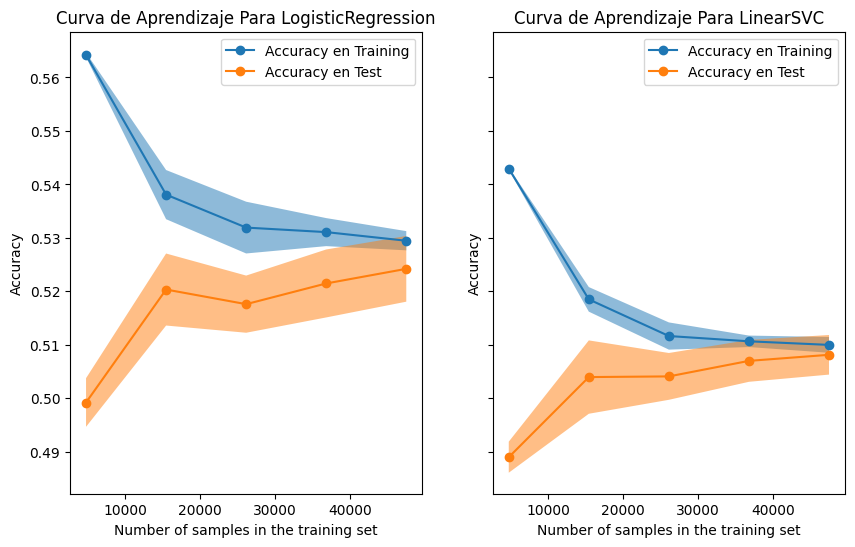

In [ ]:
#Se grafican las curvas de aprendizaje
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train_scaled,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clasificador_rl, clasificador_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Accuracy en Training", "Accuracy en Test"])
    ax[ax_idx].set_title(f"Curva de Aprendizaje Para {estimator.__class__.__name__}")